## Dog vs Cat: Image Classification

Dataset Source: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install datasets transformers tensorboard

Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import os, sys, random
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, DatasetDict

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTFeatureExtractor

import torch

import evaluate

NOTE: Redirects are currently not supported in Windows or MacOs.


##### Display Versions of Relevant Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.22.4
        Pandas: 1.4.4
      Datasets: 2.8.0
  Transformers: 4.25.1
         Torch: 1.12.1


##### Ingest Dataset

In [4]:
dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/Vit Image Datasets/Cats-vs-Dogs/PetImages", 
                        drop_labels=False)

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Using custom data configuration default-28c467983ce02ddf
Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-28c467983ce02ddf/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

##### Split Dataset into Training & Testing Datasets

In [5]:
train_split = dataset['train'].train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_split['train'],
    'test' : train_split['test']
})

##### Some Information About Train & Test Datasets

In [6]:
print(ds['train'])
print(ds['train'][0])
print(ds['train'][-1])

print(ds['test'])
print(ds['test'][0])
print(ds['test'][-1])


Dataset({
    features: ['image', 'label'],
    num_rows: 19998
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x240 at 0x7FC2D8DD7070>, 'label': 1}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7FC2D8DD7070>, 'label': 1}
Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x458 at 0x7FC2D8DD7070>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=319x400 at 0x7FC2D8DD7070>, 'label': 1}


##### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [7]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds['train'].features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (0, 0, 255), font=font)
    
    return grid

  0%|          | 0/20 [00:00<?, ?ba/s]

/Users/briandunn/Documents/nlpnn/nlp_projects/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  0%|          | 0/20 [00:00<?, ?ba/s]

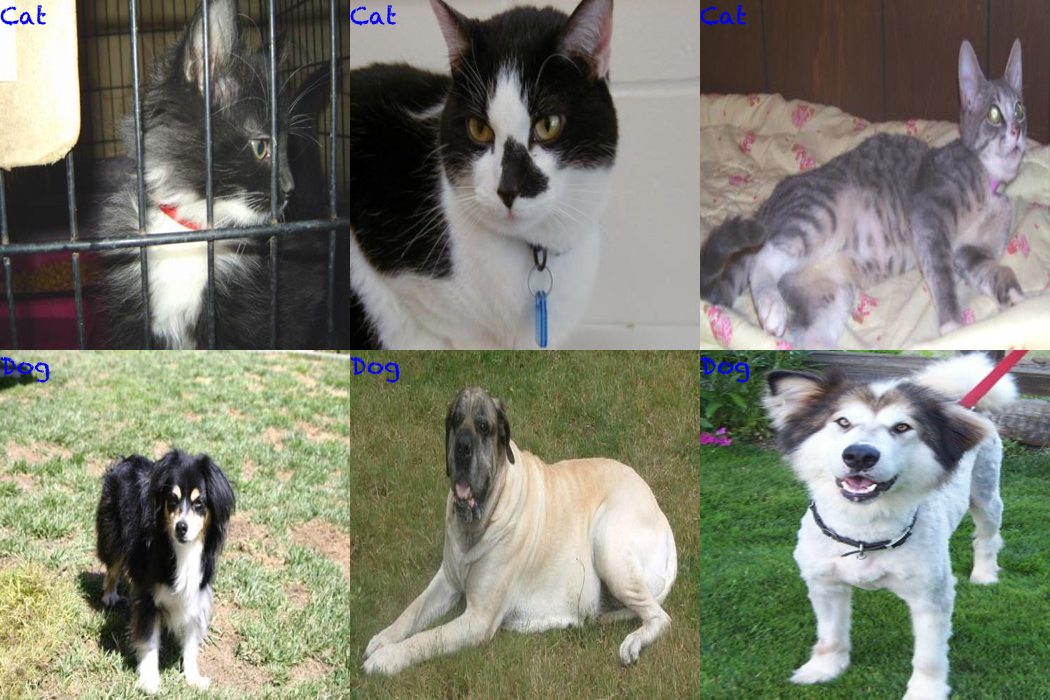

In [8]:
show_grid_of_examples(ds, seed=42, examples_per_class=3)

##### Remember to Install git lfs & Enter HuggingFace Access Token

In [9]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


##### Basic Values/Constants

In [10]:
MODEL_CKPT='google/vit-base-patch16-224-in21k'
NUM_OF_EPOCHS=3

LEARNING_RATE=2e-4
STEPS=100

BATCH_SIZE=16
DEVICE = torch.device("mps")

REPORTS_TO='tensorboard'

##### Load ViT Feature Extractor

In [11]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_CKPT)

##### Preprocessing Dataset

In [12]:
def transform(sample_batch):
    # take a list of PIL images and turn them into pixel values
    inputs = feature_extractor([x.convert("RGB") for x in sample_batch['image']], return_tensors="pt")
    
    # prepare labels
    inputs['labels'] = sample_batch['label']
    return inputs

##### Apply Transform Function to Dataset

In [13]:
prepped_ds = ds.with_transform(transform)

#### Training & Evaluation

##### Define Data Collator

In [14]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

##### Define Evaluation Metric

In [15]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["precision"]
    
    return {"accuracy" : accuracy, 
            "F1" : f1_score,
            "Recall" : recall,
            "Precision" : precision,
            }

##### Load Pretrained Model

In [16]:
labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(DEVICE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Define Training Arguments

In [17]:
args = TrainingArguments(
    output_dir=MODEL_CKPT + "_dog_vs_cat_image_classification",
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [18]:
trainer = Trainer(
    model = model,
    args = args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset = prepped_ds['train'],
    eval_dataset = prepped_ds['test'],
    tokenizer = feature_extractor,
)

/Users/briandunn/Documents/nlpnn/nlp_projects/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': private. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
/Users/briandunn/Documents/nlpnn/google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification is already a clone of https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_dog_vs_cat_image_classification. Make sure you pull the latest changes with `repo.git_pull()`.


##### Train Model

In [19]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_projects/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 19998
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Number of trainable parameters = 85800194


  0%|          | 0/3750 [00:00<?, ?it/s]

{'loss': 0.7014, 'learning_rate': 0.0001999466666666667, 'epoch': 0.0}
{'loss': 0.1057, 'learning_rate': 0.00017333333333333334, 'epoch': 0.4}


/Users/briandunn/Documents/nlpnn/nlp_projects/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


{'loss': 0.0896, 'learning_rate': 0.00014666666666666666, 'epoch': 0.8}


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


  0%|          | 0/625 [00:00<?, ?it/s]

Saving model checkpoint to google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-1250
Configuration saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-1250/config.json


{'eval_loss': 0.05895629897713661, 'eval_accuracy': 0.979, 'eval_F1': 0.978256367778008, 'eval_Recall': 0.9728171334431631, 'eval_Precision': 0.9837567680133278, 'eval_runtime': 4548.903, 'eval_samples_per_second': 1.099, 'eval_steps_per_second': 0.137, 'epoch': 1.0}


Model weights saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-1250/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-1250/preprocessor_config.json
Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/preprocessor_config.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
/Users/briandunn/Documents/nlpnn/nlp_projects/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


{'loss': 0.0471, 'learning_rate': 0.00012, 'epoch': 1.2}
{'loss': 0.0322, 'learning_rate': 9.333333333333334e-05, 'epoch': 1.6}


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


{'loss': 0.0253, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/625 [00:00<?, ?it/s]

Saving model checkpoint to google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-2500
Configuration saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-2500/config.json
Model weights saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-2500/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-2500/preprocessor_config.json


{'eval_loss': 0.05425402894616127, 'eval_accuracy': 0.9842, 'eval_F1': 0.9836743128745609, 'eval_Recall': 0.9802306425041186, 'eval_Precision': 0.9871422646204894, 'eval_runtime': 4485.3309, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.139, 'epoch': 2.0}


Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/preprocessor_config.json


{'loss': 0.0064, 'learning_rate': 4e-05, 'epoch': 2.4}


/Users/briandunn/Documents/nlpnn/nlp_projects/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


{'loss': 0.0066, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.8}


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


  0%|          | 0/625 [00:00<?, ?it/s]

Saving model checkpoint to google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-3750
Configuration saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-3750/config.json
Model weights saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-3750/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-3750/preprocessor_config.json


{'eval_loss': 0.04044065997004509, 'eval_accuracy': 0.99, 'eval_F1': 0.9897161661867544, 'eval_Recall': 0.9909390444810544, 'eval_Precision': 0.9884963023829088, 'eval_runtime': 4387.6276, 'eval_samples_per_second': 1.14, 'eval_steps_per_second': 0.142, 'epoch': 3.0}


Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/checkpoint-3750 (score: 0.9897161661867544).


{'train_runtime': 172467.8398, 'train_samples_per_second': 0.348, 'train_steps_per_second': 0.022, 'train_loss': 0.04228772549629212, 'epoch': 3.0}


#### Save Model, Metrics, & State

In [20]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification
Configuration saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/config.json
Model weights saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/preprocessor_config.json
Saving model checkpoint to google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification
Configuration saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/config.json
Model weights saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/327M [00:00<?, ?B/s]

Upload file runs/Jan10_22-21-06_Brians-Mac-mini.local/events.out.tfevents.1673410870.Brians-Mac-mini.local.204…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_dog_vs_cat_image_classification
   6ea9659..0a34ef7  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_dog_vs_cat_image_classification
   0a34ef7..9fa1d52  main -> main



***** train metrics *****
  epoch                    =                3.0
  train_loss               =             0.0423
  train_runtime            = 1 day, 23:54:27.83
  train_samples_per_second =              0.348
  train_steps_per_second   =              0.022


##### Evaluate Model

In [21]:
metrics = trainer.evaluate(prepped_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


  0%|          | 0/625 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_F1                 =     0.9897
  eval_Precision          =     0.9885
  eval_Recall             =     0.9909
  eval_accuracy           =       0.99
  eval_loss               =     0.0404
  eval_runtime            = 1:15:34.43
  eval_samples_per_second =      1.103
  eval_steps_per_second   =      0.138


##### Push Model to Hub (My Profile!)

In [22]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification
Configuration saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/config.json
Model weights saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/pytorch_model.bin
Image processor saved in google/vit-base-patch16-224-in21k_dog_vs_cat_image_classification/preprocessor_config.json


Upload file runs/Jan10_22-21-06_Brians-Mac-mini.local/events.out.tfevents.1673588364.Brians-Mac-mini.local.204…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_dog_vs_cat_image_classification
   9fa1d52..9177039  main -> main



### Notes & Other Takeaways
****
- This results of this model are excellent!
****